In [1]:
import os
import re
import gzip
import nibabel as nib
from PIL import Image
import cv2
import pydicom

import h5py
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pdb

from CompositionalNets.Code.config import vc_num, device_ids, compnet_type
from CompositionalNets.Initialization_Code.comptSimMat import compute_similarity_matrix
from CompositionalNets.Initialization_Code.vMF_clustering import learn_vmf_clusters, save_cluster_images
from CompositionalNets.Initialization_Code.Learn_mix_model_vMF_view import learn_mix_model_vMF
from CompositionalNets.Code.model import Conv1o1Layer, ActivationLayer
from CompositionalNets.Initialization_Code.config_initialization import extractor, nn_type, unet_ones
from CompositionalNets.Code.helpers import getVmfKernels
from CompositionalNets.Code.config import config as cfg

from src.config import Directories
from src.models import UNet
from src.dataset import ClassificationDataset, apply_ct_abdomen_filter, get_chaos_volumes, TripleDataset, extract_array_as_HU
from src.utils import synthetic_occlusion

%load_ext autoreload
%autoreload 2
torch.manual_seed(42)

max_images 5000


In [2]:
%%time
# TODO make this faster by reading slices from h5py instead of directly
# slicing from the volume
# vol_dir = os.path.join(Directories.CHAOS_REGISTRATIONS, 'affine', 'out')
vol_dir = os.path.join(Directories.CHAOS_REGISTRATIONS, 'affine')
regex = re.compile('.*\.nii\.gz')
names = [f for f in sorted(os.listdir(vol_dir)) if regex.match(f)]
slices = []
slice_range = (-8, 8)
volume_filepaths = get_chaos_volumes(Directories.CHAOS)

# use_masks = 'out' not in vol_dir
tight_crop = False
use_masks = True
masks = []
offset = 3

for i, name in enumerate(names):
    
    pairs = volume_filepaths[i]
    fp = os.path.join(vol_dir, name)
    
    with gzip.open(fp, 'rb') as f:

        niftii_object = nib.load(f.filename)
        volume = np.array(niftii_object.dataobj, dtype=np.int16)
        vol_min, vol_max = volume.min(), volume.max()
        
        num_slices = volume.shape[2]
        amount = np.zeros(num_slices)
        
        assert num_slices == len(pairs)
        
#         for j in range(num_slices):

#             s = volume[...,j]
#             background = s.min()
#             amount[j] = np.sum(s==background)
        
#         idx = np.argmin(amount)
# #         idx = 60
        
        if use_masks:
            for j in range(num_slices):
                liver_fp, mask_fp = pairs[j]
                                
                liver = pydicom.dcmread(liver_fp)
                array = extract_array_as_HU(liver)
                s = apply_ct_abdomen_filter(array)

                background = s.min()
                amount[j] = np.sum(s!=background)

            idx = np.argmax(amount)
            
            for k in range(idx+slice_range[0], idx+slice_range[1]):
                j = k
                if j >= len(pairs):
                    j = 0 + j % len(pairs)
                liver_fp, mask_fp = pairs[j]
                
                mask = np.array(Image.open(mask_fp), dtype=np.uint8)
                
                liver = pydicom.dcmread(liver_fp)
                array = extract_array_as_HU(liver)
                curr_slice = apply_ct_abdomen_filter(array)
                
                curr_slice = curr_slice * mask
                
                curr_min, curr_max = curr_slice.min(), curr_slice.max()
                curr_slice = (curr_slice - curr_min) / (curr_max - curr_min + 1e-12)
                curr_slice = curr_slice.astype(np.float32)
                
                # Crop around liver
                if tight_crop:
                    curr_slice = curr_slice[np.ix_((mask>0).any(1), (mask>0).any(0))]
                    mask = mask[np.ix_((mask>0).any(1), (mask>0).any(0))]
                    assert mask.shape == curr_slice.shape, f'Expected {mask.shape} == {curr_slice.shape}'

                curr_slice = np.stack((curr_slice, curr_slice, curr_slice), axis=len(curr_slice.shape))
                
                slices.append(curr_slice)
                masks.append(mask)
                
        else:
            for j in range(num_slices):

                s = volume[...,j]
                background = s.min()
                amount[j] = np.sum(s==background)

            idx = np.argmin(amount)
    #         idx = 60
    
            curr_slices = volume[..., idx+slice_range[0]:idx+slice_range[1]]

            curr_slices = apply_ct_abdomen_filter(curr_slices)

            curr_min, curr_max = curr_slices.min(), curr_slices.max()
            curr_slices = (curr_slices - curr_min) / (curr_max - curr_min + 1e-12)

            curr_slices = np.transpose(curr_slices, (2, 0, 1))
            curr_slices = np.stack((curr_slices, curr_slices, curr_slices), axis=len(curr_slices.shape))
            curr_slices = np.rot90(curr_slices, k=1, axes=(1,2))
            curr_slices = curr_slices.astype(np.float32)
        
            # Crop around liver
            if tight_crop:
                curr_slices = [img[np.ix_((img[...,0]>0).any(1), (img[...,0]>0).any(0))] for img in curr_slices]
        
            slices.extend(curr_slices)
        
slices = np.asarray(slices)
if use_masks:
    train_slices, test_slices, train_masks, test_masks = train_test_split(slices, masks, test_size=0.2, random_state=42)
    dataset = TripleDataset(train_slices, train_masks, [0] * len(train_slices), X_transform=transforms.ToTensor())
else:
    train_slices, test_slices = train_test_split(slices, test_size=0.2, random_state=42)
    dataset = ClassificationDataset(train_slices, [0] * len(train_slices), input_transform=transforms.ToTensor())
    
data_loader = DataLoader(dataset, batch_size=1)

synthetic_images = synthetic_occlusion(test_slices[:20], textured=False, color=0.78431374)
for i in range(8):
    try:
        im = Image.open(os.path.join(Directories.DATA, 'tumors', f'tumor_slice{i}.jpg'))
        im = (np.array(im).astype(np.float32) / 255)
        synthetic_images[i] = im
    except Exception as e:
        print(f'{e}')

/home/mattlk/.virtualenvs/CompNet/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: use the name attribute


CPU times: user 27.5 s, sys: 16.3 s, total: 43.7 s
Wall time: 3min 42s


In [5]:
mask = train_masks[10]
mask_tensor = torch.Tensor(mask).unsqueeze(0).unsqueeze(0)
with torch.no_grad():
    mask_feature_map = unet_ones(mask_tensor)
    mask_extractor_feature_map = extractor(torch.Tensor(
        np.stack((mask, mask, mask), axis=len(mask.shape))).permute(2, 0, 1).unsqueeze(0).cuda(device_ids[0]))

In [6]:
mask_feature_map = mask_feature_map.squeeze().detach().cpu().numpy()
mask_extractor_feature_map = mask_extractor_feature_map.squeeze().detach().cpu().numpy()
# mask_feature_map = mask_feature_map[0,...]

In [31]:
indices = np.argwhere(mask_feature_map[0,...] > mask_feature_map[0,...].min())
new_f_map = np.zeros(mask_feature_map[0,...].shape)
new_f_map[indices] = 1

In [30]:
mask_feature_map[0,...].min()

47516293000000.0

In [24]:
new_f_map.shape

(4096, 2)

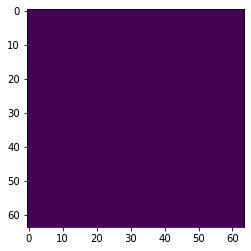

In [32]:
plt.imshow(new_f_map)

In [29]:
np.unique(new_f_map)

array([0.])

In [ ]:
np.unique(mask_feature_map[0,...])

In [17]:
mask_f_map = mask_feature_map[0,...]
mask_f_map = (mask_f_map - mask_f_map.min()) / (mask_f_map.max() - mask_f_map.min() + 1e-12)

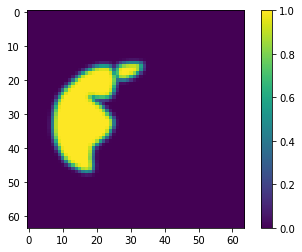

In [18]:
plt.imshow(mask_f_map)
plt.colorbar()

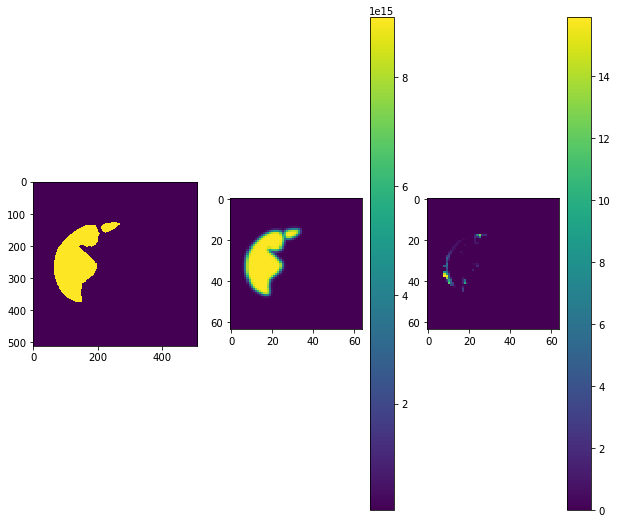

In [15]:
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(mask)
plt.subplot(132)
plt.imshow(mask_feature_map[0,...])
plt.colorbar()
plt.subplot(133)
plt.imshow(mask_extractor_feature_map[0,...])
plt.colorbar()

In [8]:
mask_min, mask_max = mask_feature_map.min(), mask_feature_map.max()
mask_feature_map = (mask_feature_map - mask_min) / (mask_max - mask_min + 1e-12)
# mask_feature_map[mask_feature_map == mask_feature_map.min()] = 0
# mask_feature_map[mask_feature_map != mask_feature_map.min()] = 1

In [9]:
threshold = 0.75
ff = mask_feature_map[0] > threshold

flat_mask = mask_feature_map.reshape(mask_feature_map.shape[0], -1)
ff2 = np.argwhere(flat_mask[0] > threshold).reshape(-1)

ff2.shape

(364,)

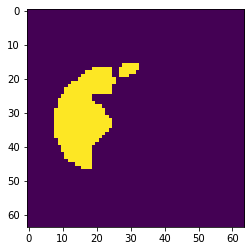

In [10]:
plt.imshow(ff)

# Clustering

In [3]:
# for kappa in range(60, 61, 10):
#     experiment = 32
#     kappas = [kappa]
#     vmf, loc_set =  learn_vmf_clusters(data_loader, img_per_cat=len(dataset), verbose=True,
#                                        max_it=1000, tol=5e-12,
#                                        u_out_name=f'chaos_pool5_{vc_num}_u_test_{experiment}.pickle',
#                                        p_out_name=f'chaos_pool5_{vc_num}_p_test_{experiment}.pickle',
#                                        kappas=kappas)
#     save_cluster_images(vmf, loc_set, in_images=train_slices*255,
#                         num_images=16, out_dir_name=f'test_{experiment}_{kappa}',
#                         max_num_clusters=30)

In [4]:
experiment = 76
kappa = 55

In [5]:
%%time
vmf, loc_set = learn_vmf_clusters(data_loader, img_per_cat=len(dataset), verbose=True,
                                   max_it=50, tol=5e-12,
                                   u_out_name=f'chaos_pool5_{vc_num}_u_test_{experiment}.pickle',
                                   p_out_name=f'chaos_pool5_{vc_num}_p_test_{experiment}.pickle',
                                   kappas=55, use_mask=True)

4985.546875 MB


CPU times: user 10min 33s, sys: 1min 16s, total: 11min 49s
Wall time: 3min 54s


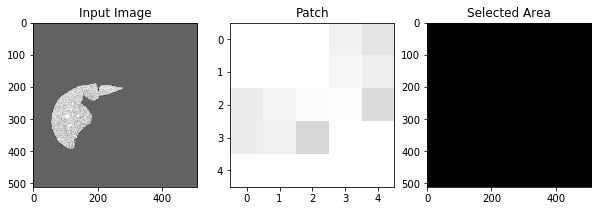

In [44]:
# i, x1, y1, x2, y2= iloc[0][0].astype(int)
_, ii, x1, y1, x2, y2= SORTED_LOC[vc_i][2].astype(int)
patch = train_slices[i][x1:x2, y1:y2, :]

center_idx = ((x2 - x1) // 2, (y2 - y1) // 2)
matrix = np.zeros((train_slices[i].shape))
matrix[center_idx[0]-2:center_idx[0]+3, center_idx[1]-2:center_idx[1]+3, :] = 1

plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.title('Input Image')
plt.imshow(train_slices[i])
plt.subplot(132)
plt.title('Patch')
plt.imshow(patch)
plt.subplot(133)
plt.title('Selected Area')
plt.imshow(train_slices[i] * matrix)

In [6]:
save_cluster_images(vmf, loc_set, in_images=train_slices*255,
                    num_images=16, out_dir_name=f'test_{experiment}',
                    max_num_clusters=max(20, vc_num))

Saving top 16 images for each cluster


In [7]:
# sort_idx = np.argsort(-vmf.p[:, 1])[0:16]
# print(sort_idx)
# print(np.sort(-vmf.p[:, 1])[0:16])
# differences = [a - b for a,b in zip(np.sort(-vmf.p[:, 1])[0:16], np.sort(-vmf.p[:, 1])[1:17])]
# plt.plot(differences)

# Visualize VMF Kernel Activations 

In [ ]:
encoder = 'unet'
dict_dir = os.path.join(Directories.COMPOSITIONAL_NETS,
                        f'models/init_{encoder}/dictionary_{encoder}/chaos_pool5_{vc_num}_u_test_{experiment}.pickle')
weights = getVmfKernels(dict_dir, device_ids)

conv1o1 = Conv1o1Layer(weights)
activation_layer = ActivationLayer(kappa, compnet_type, 
                                   threshold=cfg.MODEL.VC_THRESHOLD)

In [7]:
if use_masks:
    image, mask, label = dataset[15]
else:
    image, label = dataset[0]
image = image.unsqueeze(0)

if device_ids:
    image = image.cuda(device_ids[0])
features = extractor(image)
vc_activations = conv1o1(features)
vc_activations = vc_activations.detach().squeeze().cpu().numpy()
# vmf_activations = activation_layer(vc_activations)
# vmf_activations = vmf_activations.detach().squeeze().cpu().numpy()
image = image.detach().cpu().squeeze().permute(1,2,0).numpy()

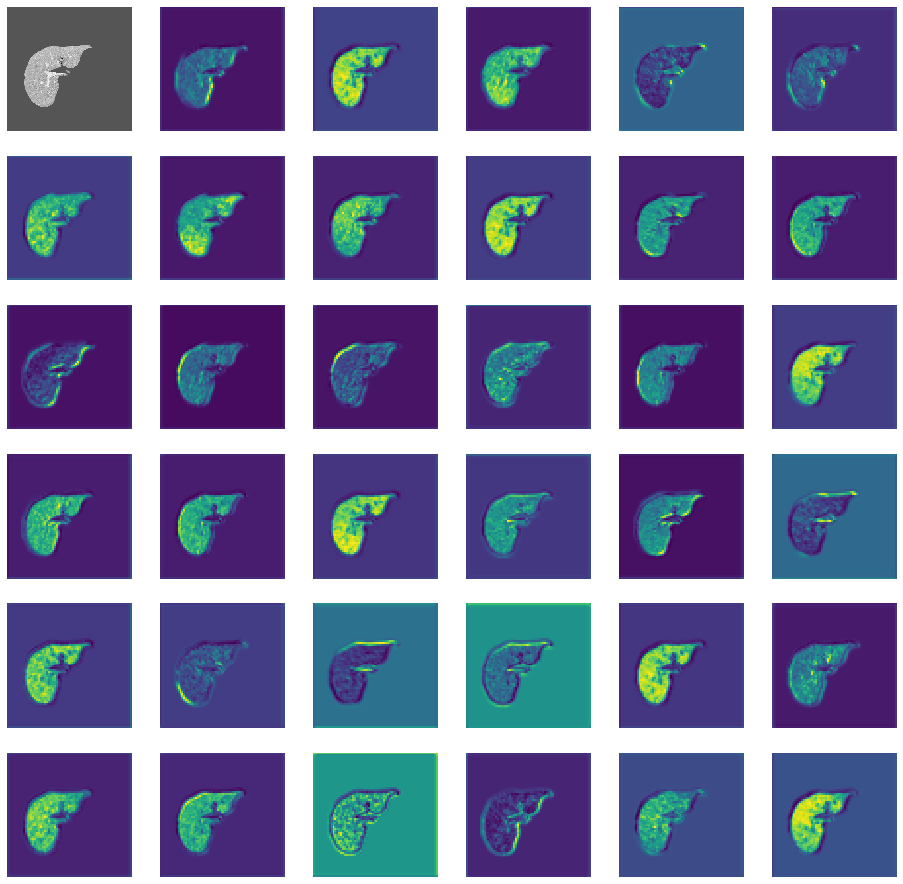

In [8]:
plt.figure(figsize=(16, 16))
plt.subplot(661)
plt.imshow(image)
plt.axis('off')


# TODO only VC activations
# TODO try different kappas 
# TODO try less clusters (200 too many?)
for i in range(35):
    plt.subplot(6, 6, 2+i)
    plt.imshow(vc_activations[i,...])
    plt.axis('off')
plt.show()

# Learn Mixtures

In [6]:
%%time
mat1, mat2 = compute_similarity_matrix(data_loader, 0, f'test_{experiment}',
                                       sim_dir_name=f'similarity_{nn_type}_pool5_chaos_{experiment}',
                                       u_out_name=f'chaos_pool5_{vc_num}_u_test_{experiment}.pickle',
                                       N_sub=min(5, len(dataset)//10), num_layer_features=min(100, len(dataset)), num_centers_threshold=300)

Determine best threshold for binarization - 0 ...
Start compute sim matrix ... magicThresh 0.2
iter 1/52 1/52
comptSimMat iter time: 0.1058892806371053
iter 1/52 2/52
comptSimMat iter time: 0.1401453455289205
iter 1/52 3/52
comptSimMat iter time: 0.12909125884373981
iter 1/52 4/52
comptSimMat iter time: 0.13418589035669962
iter 1/52 5/52
comptSimMat iter time: 0.1314146598180135
iter 1/52 6/52
comptSimMat iter time: 0.13718738158543906
iter 1/52 7/52
comptSimMat iter time: 0.13028492530186972
iter 1/52 8/52
comptSimMat iter time: 0.12807568709055583
iter 1/52 9/52
comptSimMat iter time: 0.13679571946461996
iter 1/52 10/52
comptSimMat iter time: 0.1278539220492045
iter 1/52 11/52
comptSimMat iter time: 0.12988369464874266
iter 1/52 12/52
comptSimMat iter time: 0.13185474872589112
iter 1/52 13/52
comptSimMat iter time: 0.13101698954900107
iter 1/52 14/52
comptSimMat iter time: 0.13275280396143596
iter 1/52 15/52
comptSimMat iter time: 0.13023462692896526
iter 1/52 16/52
comptSimMat iter 

In [7]:
learn_mix_model_vMF(data_loader, 0, sim_matrix_name=f'test_{experiment}',
                    num_layers=1, num_clusters_per_layer=1,
                    sim_dir_name=f'similarity_{nn_type}_pool5_chaos_{experiment}',
                    dict_filename=f'chaos_pool5_{vc_num}_u_test_{experiment}.pickle',
                    mixdir_name=f'mix_model_vmf_chaos_EM_all_test_{experiment}/',
                    im_channels=3)

total number of instances for obj 0: 256
100 64 64
Clustering layer 0 ...
0 0 256 0
cluster 0 has 256 samples

ML Step 0 / 10
0
100
200
cluster 0 has 256 samples
0 changed assignments


# Localize Occluders on Synthetic

In [8]:
import cv2
from CompositionalNets.Code.config import categories, device_ids, categories_train, mix_model_path, dict_dir, layer, vMF_kappa, num_mixtures
from CompositionalNets.Code.model import Net
from CompositionalNets.Code.helpers import getVmfKernels, getCompositionModel
from CompositionalNets.Code.eval_occlusion_localization import visualize_response_map, eval_occ_detection

In [9]:
encoder = 'unet'
num_clusters = 100
experiment = 70
occ_likely = [0.6 for _ in range(len(categories_train))]

dict_dir = os.path.join(Directories.COMPOSITIONAL_NETS,
                        f'models/init_{encoder}/dictionary_{encoder}/chaos_pool5_{num_clusters}_u_test_{experiment}.pickle')
weights = getVmfKernels(dict_dir, device_ids)
mix_model_path = os.path.join(Directories.COMPOSITIONAL_NETS, 
                             f'models/init_{encoder}/mix_model_vmf_chaos_EM_all_test_{experiment}/')
mix_models = getCompositionModel(device_ids, mix_model_path, layer,
                                 [0],
                                 compnet_type=compnet_type,
                                 num_mixtures=num_mixtures)

model = Net(extractor, weights, vMF_kappa, occ_likely, mix_models,
            bool_mixture_bg=True,
            compnet_type=compnet_type, num_mixtures=num_mixtures, 
            vc_thresholds=cfg.MODEL.VC_THRESHOLD, occlusion_threshold=21)

if device_ids:
    model.to(device_ids[0])

In [ ]:
cc = transforms.Compose([
    transforms.ToTensor(),
])

i = 0
out_dir = f'{Directories.COMPOSITIONAL_NETS}/models/init_{encoder}/occlusion_maps/test_{experiment}/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
for i, image in enumerate(synthetic_images[:]):
    
    if tight_crop:
        image = image[np.ix_((image[...,0]>0).any(1), (image[...,0]>0).any(0))]
    image = cc(image)

    if device_ids:
        image = image.cuda(device_ids[0])

    image = image.unsqueeze(0)
    try:
        with torch.no_grad():
            score, occ_maps, part_scores = model.get_occlusion(image, 0)
            deconvs = model.vc_activation_deconv(image)

        occ_map = occ_maps[0].detach().cpu().numpy()
        occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
        occ_img = visualize_response_map(occ_map, tit='', cbarmax=0)

        img_orig = (image[0].permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
        faco = img_orig.shape[0] / occ_img.shape[0]

        occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))[:,:img_orig.shape[1],:]
        
        canvas = np.concatenate((img_orig, occ_img_s), axis=1)
        plt.figure(figsize=(7, 7))
        plt.imshow(img_orig)
        plt.imshow(occ_img_s, alpha=0.5, cmap="gray")
        plt.imshow(canvas)
        plt.axis('off')
#         plt.colorbar()
        plt.imsave(os.path.join(out_dir, f'{i:02d}.jpg'), canvas)
#         break
    except Exception as e:
        print(e)

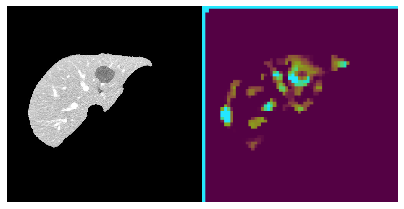

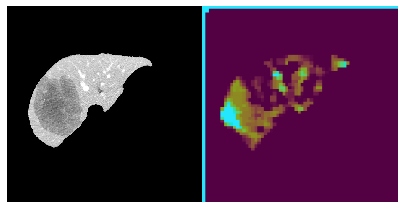

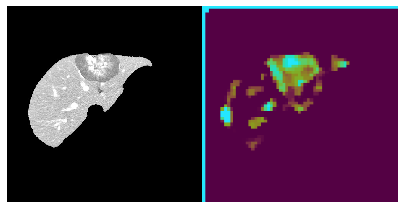

In [ ]:
cc = transforms.Compose([
    transforms.ToTensor(),
])

i = 0
out_dir = f'{Directories.COMPOSITIONAL_NETS}/models/init_{encoder}/occlusion_maps/test_{experiment}/'
for image in synthetic_images[:]:
    
    if tight_crop:
        image = image[np.ix_((image[...,0]>0).any(1), (image[...,0]>0).any(0))]
    image = cc(image)

    if device_ids:
        image = image.cuda(device_ids[0])

    image = image.unsqueeze(0)
    try:
        with torch.no_grad():
            score, occ_maps, part_scores = model.get_occlusion(image, 0)
            deconvs = model.vc_activation_deconv(image)

        occ_map = occ_maps[0].detach().cpu().numpy()
        occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
        occ_img = visualize_response_map(occ_map, tit='', cbarmax=0)

        img_orig = (image[0].permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
        faco = img_orig.shape[0] / occ_img.shape[0]

        occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))[:,:img_orig.shape[1],:]
        
        canvas = np.concatenate((img_orig, occ_img_s), axis=1)
        plt.figure(figsize=(7, 7))
        plt.imshow(img_orig)
        plt.imshow(occ_img_s, alpha=0.5, cmap="gray")
        plt.imshow(canvas)
        plt.axis('off')
#         break
    except Exception as e:
        print(e)

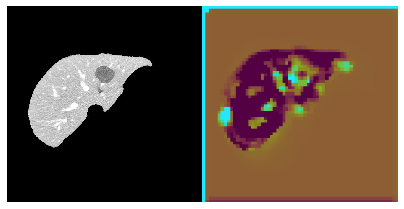

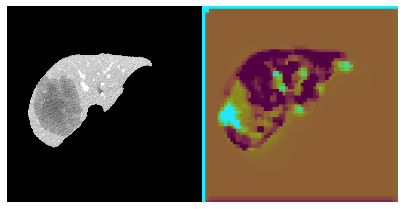

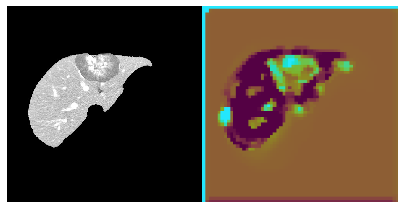

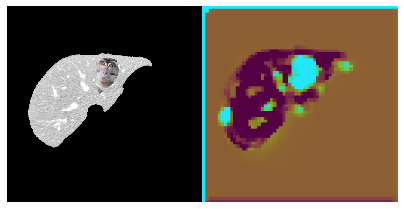

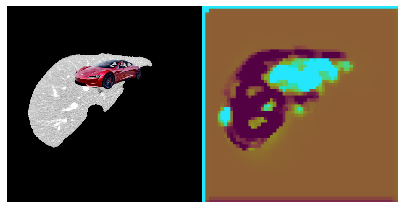

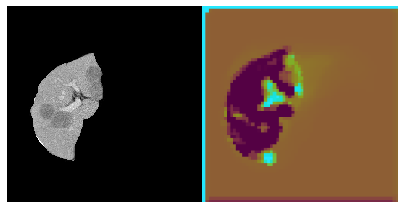

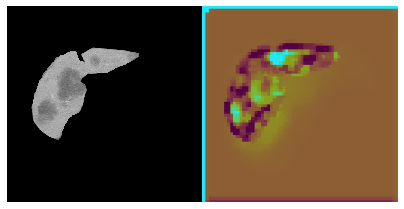

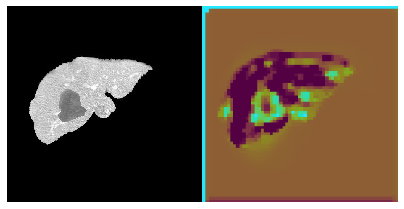

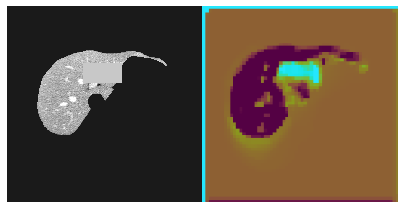

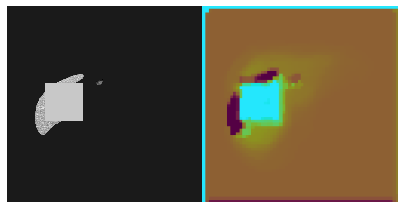

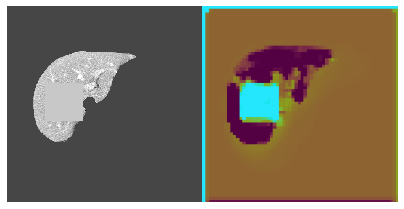

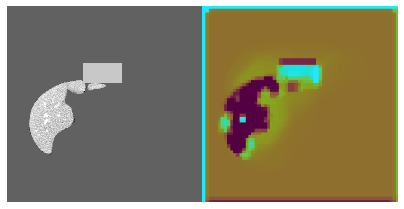

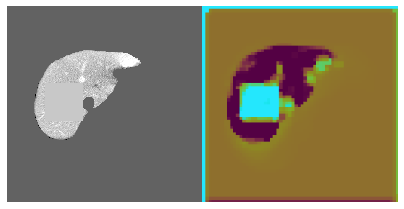

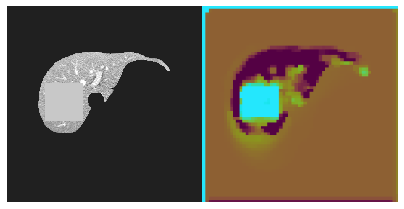

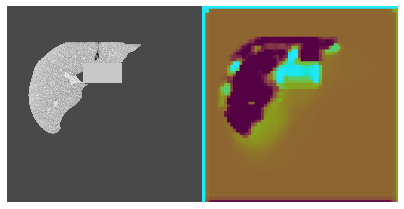

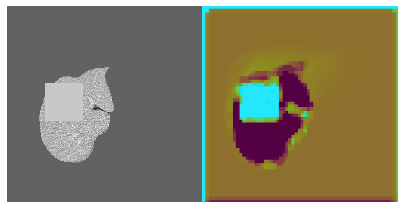

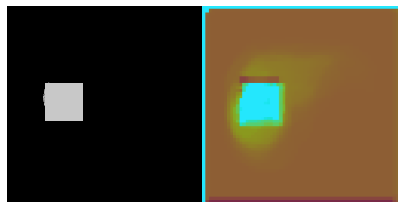

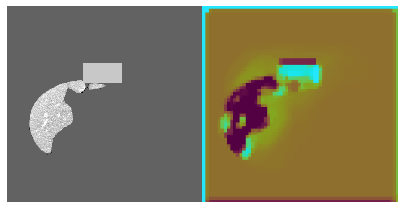

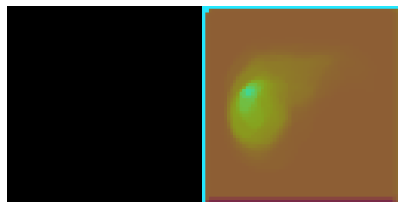

In [19]:
cc = transforms.Compose([
    transforms.ToTensor(),
])

i = 0
out_dir = f'{Directories.COMPOSITIONAL_NETS}/models/init_{encoder}/occlusion_maps/test_{experiment}/'
for image in synthetic_images[:]:
    
    if tight_crop:
        image = image[np.ix_((image[...,0]>0).any(1), (image[...,0]>0).any(0))]
    image = cc(image)

    if device_ids:
        image = image.cuda(device_ids[0])

    image = image.unsqueeze(0)
    try:
        with torch.no_grad():
            score, occ_maps, part_scores = model.get_occlusion(image, 0)
            deconvs = model.vc_activation_deconv(image)

        occ_map = occ_maps[0].detach().cpu().numpy()
        occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
        occ_img = visualize_response_map(occ_map, tit='', cbarmax=0)

        img_orig = (image[0].permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
        faco = img_orig.shape[0] / occ_img.shape[0]

        occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))[:,:img_orig.shape[1],:]
        
        canvas = np.concatenate((img_orig, occ_img_s), axis=1)
        plt.figure(figsize=(7, 7))
        plt.imshow(img_orig)
        plt.imshow(occ_img_s, alpha=0.5, cmap="gray")
        plt.imshow(canvas)
        plt.axis('off')
#         break
    except Exception as e:
        print(e)

# Localize Real Tumors

In [2]:
tight_crop = False

In [3]:
data_dir = os.path.join(Directories.LITS, 'media', 'nas', '01_Datasets', 'CT', 'LITS')
data_train_dir = os.path.join(data_dir, 'Training Set')
data_test_dir = os.path.join(data_dir, 'Testing Set')

volume_filepaths = [os.path.join(data_train_dir, name) for name in sorted(os.listdir(data_train_dir)) 
                    if 'volume' in name]
segmentation_filepaths = [os.path.join(data_train_dir, name) for name in sorted(os.listdir(data_train_dir)) 
                          if 'segmentation' in name]

pairs = [(vol, gt) for vol, gt in zip(volume_filepaths, segmentation_filepaths)]

cc = transforms.Compose([
    transforms.ToTensor(),
])

out_dir = f'{Directories.COMPOSITIONAL_NETS}/models/init_{nn_type}/occlusion_maps/test_lits_{experiment}/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

for pair_num, (volume_fp, segmentation_fp) in enumerate(pairs[3:4]):
    i = 0
    
    volume = nib.load(volume_fp)
    segmentation = nib.load(segmentation_fp)
    
    volume_data = volume.get_fdata()
    segmentation_data = segmentation.get_fdata()
    vol_min = volume_data.min()
    vol_max = volume_data.max()
    
    _, _, num_slices = volume_data.shape
    
    test_images = []
    for j in range(num_slices):
        image = volume_data[...,j]
        target = segmentation_data[...,j]

        image = np.array(image)
        target = np.array(target)
        
        image = np.rot90(image, k=1)
        target = np.rot90(target, k=1)

        liver = target.copy()
        liver[target == 2] = 1
        
        tumor = target.copy()
        tumor[target == 1] = 0
        tumor[target == 2] = 1

        if np.sum(liver) > 10000:
            
            image = image * liver
            
            image = (image - image.min()) / (image.max() - image.min() + 1e-12)
            image = image.astype(np.float32)
            image = np.stack((image, image, image), axis=2)
            
            if tight_crop:
                image = image[np.ix_((image[...,0]>0).any(1), (image[...,0]>0).any(0))]
                
            image = cc(image)
            if device_ids:
                image = image.cuda(device_ids[0])
            image = image.unsqueeze(0)

            score, occ_maps, part_scores = model.get_occlusion(image, 0)
            occ_map = occ_maps[0].detach().cpu().numpy()
            occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
            occ_img = visualize_response_map(occ_map, tit='', cbarmax=0)

            img_orig = (image[0].permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
            faco = img_orig.shape[0] / occ_img.shape[0]
            
            if tight_crop:
                img_orig = img_orig[np.ix_((img_orig[...,0]>0).any(1), (img_orig[...,0]>0).any(0))]
            
            occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))[:,:img_orig.shape[1],:]
            canvas = np.concatenate((img_orig, occ_img_s, np.stack((target,target,target),axis=2)*255/2), axis=1)
            cv2.imwrite(os.path.join(out_dir, f'{pair_num:02d}_{i:02d}.jpg'), canvas)
            i += 1

NameError: name 'Directories' is not defined

In [110]:
tumor = np.stack((tumor, tumor, tumor), axis=2)

In [112]:
out = eval_occ_detection(occ_img_s, tumor)
best_score = 0
best_scores = []
for scores in out:
    acc_score = scores[-1]
    if acc_score > best_score:
        best_score = acc_score
        best_scores = scores

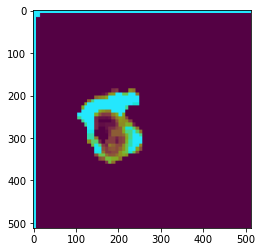

In [146]:
plt.imshow(occ_img_s)

In [18]:
result

(512, 512, 3)

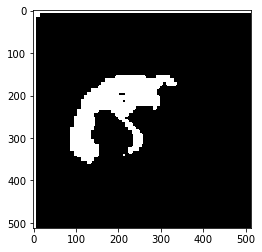

In [25]:
result = (occ_img_s > 100) * occ_img_s
result[result != 0] = 255
result = result[...,2]
plt.imshow(result, cmap="gray")

# Test on Real Tumors from Peter

In [43]:
image_paths = [os.path.join(Directories.BASELINES, name) for name in os.listdir(Directories.BASELINES) if 'real_tumor' in name]
images = [np.array(Image.open(path), dtype=np.uint32) for path in image_paths]
images = [(im - im.min()) / (im.max() - im.min() + 1e-12) for im in images]
images = [im.astype(np.float32) for im in images]

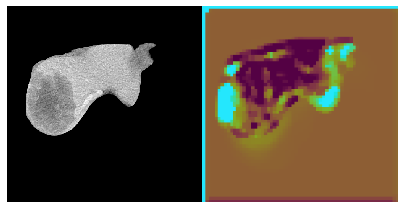

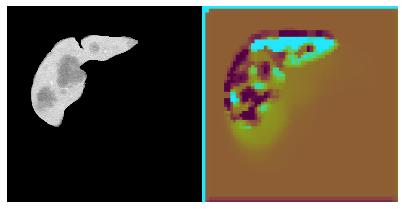

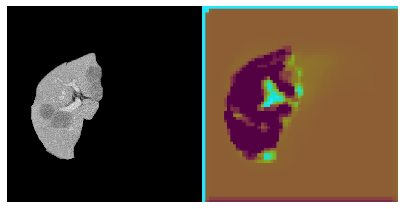

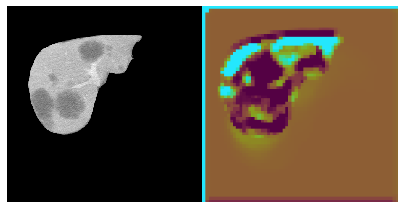

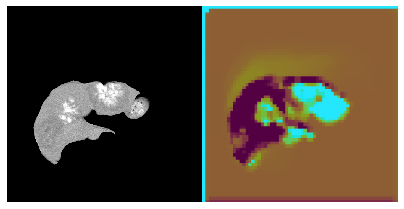

In [46]:
cc = transforms.Compose([
    transforms.ToTensor(),
])

i = 0
out_dir = f'{Directories.COMPOSITIONAL_NETS}/models/init_{encoder}/occlusion_maps/test_{experiment}/'
for i, image in enumerate(images):
    
    if tight_crop:
        image = image[np.ix_((image[...,0]>0).any(1), (image[...,0]>0).any(0))]
    image = cc(image)

    if device_ids:
        image = image.cuda(device_ids[0])

    image = image.unsqueeze(0)
    try:
        with torch.no_grad():
            score, occ_maps, part_scores = model.get_occlusion(image, 0)
            deconvs = model.vc_activation_deconv(image)

        occ_map = occ_maps[0].detach().cpu().numpy()
        occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
        occ_img = visualize_response_map(occ_map, tit='', cbarmax=0)

        img_orig = (image[0].permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
        faco = img_orig.shape[0] / occ_img.shape[0]

        occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))[:,:img_orig.shape[1],:]
        
        canvas = np.concatenate((img_orig, occ_img_s), axis=1)
        plt.figure(figsize=(7, 7))
#         plt.imshow(img_orig)
#         plt.imshow(occ_img_s, alpha=0.5, cmap="gray")
        plt.imshow(canvas)
        plt.axis('off')
        plt.imsave(os.path.join(out_dir, f'real_tumor_{i}.png'), canvas)
#         break
    except Exception as e:
        print(e)

# Backup

In [ ]:
cc = transforms.Compose([
    transforms.ToTensor(),
])

i = 0
with torch.no_grad():
    for image, target in zip(image_dataset, target_dataset):
        
        image = apply_ct_abdomen_filter(image)
    
        image = np.stack((image, image, image), axis=2)

        # Normalize between 0 and 1
        image = (image - image_dataset.min()) / (image_dataset.max() - image_dataset.min() + 1e-12)
        image = image.astype(np.float32)
        
        if tight_crop:
            image = image[np.ix_((image[...,0]>0).any(1), (image[...,0]>0).any(0))]
        
        image = cc(image)
        
        if device_ids:
            image = image.cuda(device_ids[0])
        image = image.unsqueeze(0)
        
        image = image.squeeze(0).permute(1,2,0).cpu().numpy()
        
        image = cc(image)
        image = image.unsqueeze(0)
        image = image.cuda()

        score, occ_maps, part_scores = model.get_occlusion(image, 0)
        occ_map = occ_maps[0].detach().cpu().numpy()
        occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
        occ_img = visualize_response_map(occ_map, tit='', cbarmax=0)
        
        img_orig = (image[0].permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
        faco = img_orig.shape[0] / occ_img.shape[0]
        
        occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))
        
        canvas = np.concatenate((img_orig, occ_img_s), axis=1)
#         plt.figure(figsize=(8, 8))
#         plt.imshow(canvas)
#         plt.axis('off')
#         fp = f'{Directories.COMPOSITIONAL_NETS}/results/lits/train_without_occluder/test_{i}.png'
#         cv2.imwrite(fp, canvas)

In [39]:
tumor_dir = os.path.join(Directories.DATA, 'tumors')
tumors = [cv2.imread(os.path.join(tumor_dir, name)) for name in os.listdir(tumor_dir)]

In [40]:
train_hdf5_fp = os.path.join(Directories.LITS, 'train.hdf5')
with h5py.File(train_hdf5_fp, 'r') as hf:
    image_dataset = hf['images'][40:60]
    target_dataset = hf['masks'][40:60]

tumors = []
for im in image_dataset:
    im = apply_ct_abdomen_filter(im)
    
    im = np.stack((im, im, im), axis=2)

    # Normalize between 0 and 1
    im = (im - im.min()) / (im.max() - im.min())
    im = im.astype(np.float32)
    tumors.append(im)

unet_filename = 'unet_liver_2020-08-13_15:52:08.pth'
is_cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if is_cuda_available else "cpu")

path_to_unet = os.path.join(Directories.CHECKPOINTS, unet_filename)
unet = UNet(pretrained=True)
unet.load_state_dict(torch.load(path_to_unet)['model_state_dict'])
if is_cuda_available: unet.to(device)

In [ ]:
cc = transforms.Compose([
    transforms.ToTensor(),
])

i = 0
with torch.no_grad():
    for image in tumors[:10]:
        
        image = cc(image)
        
        if device_ids:
            image = image.cuda(device_ids[0])
        image = image.unsqueeze(0)
        
        out = unet(image)
        scores = F.softmax(out, dim=1)

        segmentations = torch.round(F.threshold(scores[:, 1, :, :], 0.9, 0))
        processed_images = segmentations.unsqueeze(1) * image
        
        seg_liver = processed_images.squeeze()
        image = seg_liver.unsqueeze(0)
        
        image = image.squeeze(0).permute(1,2,0).cpu().numpy()
        image = image[np.ix_((image[...,0]>0).any(1), (image[...,0]>0).any(0))]
        image = cc(image)
        image = image.unsqueeze(0)
        image = image.cuda()

        score, occ_maps, part_scores = model.get_occlusion(image, 0)
        occ_map = occ_maps[0].detach().cpu().numpy()
        occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
        occ_img = visualize_response_map(occ_map, tit='', cbarmax=0)
        
        img_orig = (image[0].permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
        faco = img_orig.shape[0] / occ_img.shape[0]
        
        occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))
        
        canvas = np.concatenate((img_orig, occ_img_s), axis=1)
        plt.figure(figsize=(8, 8))
        plt.imshow(canvas)
        plt.axis('off')
#         fp = f'{Directories.COMPOSITIONAL_NETS}/results/lits/train_without_occluder/test_{i}.png'
#         cv2.imwrite(fp, canvas)